# Cheat sheet

#### Models
1. Decision Tree
2. Random Forest
3. Adaboost
4. Gradient Boost
5. K-Means
6. Gaussian Mixed Model
7. Neural Network

#### Preprocessing
1. PCA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. Decision Tree

In [2]:
class DecisionTree:
    def __init__(self,max_depth):
        self.root = None
        self.max_depth = max_depth
        
    class Node: 
        def __init__(self, gini, num_samples, num_samples_per_class, predicted_class):
            self.gini = gini
            self.num_samples = num_samples
            self.num_samples_per_class = num_samples_per_class
            self.predicted_class = predicted_class
            self.feature_index = 0
            self.threshold = 0
            self.left = None
            self.right = None
            
    def find_split(self, X,y,n_classes):
        n_samples, n_features = X.shape
        if n_samples <= 1:
            return None, None

        #so it will not have any warning about "referenced before assignments"
        feature_ix, threshold = None, None

        #count the samples for each class
        sample_per_class_parent = [np.sum(y == c) for c in range(n_classes)]

        # Gini of parent node.
        best_gini = 1.0 - sum((n / n_samples) ** 2 for n in sample_per_class_parent)

        # Loop through all features.
        for feature in range(n_features):
            # Sort data along selected feature.
            sample_sorted = sorted(X[:, feature]) #[2, 3, 10, 19]
            sort_idx = np.argsort(X[:, feature])
            y_sorted = y[sort_idx] #[0, 0, 1, 1]
            sample_per_class_left = [0] * n_classes
            #[0, 0]
            sample_per_class_right = sample_per_class_parent.copy() #[2, 2]
            # loop through each threshold, 2.5, 6.5, 14.5
            for i in range(1, n_samples):
                #the class of that sample
                c = y_sorted[i - 1] #[0]
                #put the sample to the left
                
                sample_per_class_left[c] += 1
                #[1, 0]
                #take the sample out from the right
                sample_per_class_right[c] -= 1

                gini_left = 1.0 - sum((sample_per_class_left[x] / i) ** 2 for x in range(n_classes))

                #since left side has already i samples
                gini_right = 1.0 - sum(
                (sample_per_class_right[x] / (n_samples - i)) ** 2 for x in range(n_classes)
                )
                #weighted gini
                weighted_gini = (i / n_samples) * gini_left + ((n_samples - i)/n_samples) * gini_right

                # in case the value are the same, we do not split
                # (both have to end up on the same side of a split).
                if sample_sorted[i] == sample_sorted[i - 1]:
                    continue
                if weighted_gini < best_gini:
                    best_gini = weighted_gini
                    feature_ix = feature
                    threshold = (sample_sorted[i] + sample_sorted[i - 1]) / 2

        return feature_ix, threshold
    
    def fit(self,X,y):
        self.root = self._fit(X,y,len(set(y)))
    
    def _fit(self,X,y,n_classes,depth = 0):
        assert y.dtype == int
        
        n_samples,n_features = X.shape
        num_samples_per_class = [np.sum(y == i) for i in range(n_classes)]
        predicted_class = np.argmax(num_samples_per_class)

        node = self.Node(
            gini = 1-sum((np.sum(y==c)/n_samples)**2 for c in range(n_classes)),
            predicted_class = predicted_class,
            num_samples = y.size,
            num_samples_per_class = num_samples_per_class
        )

        if (depth >= self.max_depth):
            return node
        
        feature, threshold = self.find_split(X,y,n_classes)
        if feature is not None:
            indices_left = X[:,feature] < threshold
            X_left, y_left = X[indices_left], y[indices_left]
            #tilde for negation
            X_right, y_right = X[~indices_left], y[~indices_left]
            #take note for later decision
            node.feature_index = feature
            node.threshold = threshold
            node.left = self._fit(X_left, y_left, n_classes, depth + 1)
            node.right = self._fit(X_right, y_right, n_classes, depth + 1)
        return node

    def predict(self,sample):
        tree = self.root
        while tree.left:
            if sample[tree.feature_index] < tree.threshold:
                tree = tree.left 
            else:
                tree = tree.right 
        return tree.predicted_class

In [3]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

X, y = make_blobs(n_samples=1000, centers=4,random_state=0, cluster_std=1.0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
tree = DecisionTree(max_depth = 7)

tree.fit(X_train,y_train)

In [5]:
pred = [tree.predict(x) for x in X_test]
print("Prediction:\t",np.array(pred))
print("Y:\t\t", y_test)
print("Accuracy", 100*np.sum(y_test==np.array(pred))/y_test.size)

Prediction:	 [3 0 0 3 0 1 1 3 1 2 0 0 0 1 2 0 1 3 1 3 2 2 1 1 0 1 2 3 3 3 1 3 0 0 3 2 1
 1 2 3 3 2 3 2 3 3 0 3 3 2 2 0 3 1 1 1 1 3 0 3 3 3 0 0 1 2 3 2 3 1 3 2 1 0
 0 3 2 2 0 0 3 1 3 2 0 2 3 0 1 1 2 3 0 1 3 2 1 2 2 2 1 1 2 2 2 1 3 0 0 0 0
 2 3 0 2 2 0 2 2 3 0 0 3 1 1 2 0 1 0 3 2 2 2 3 1 1 1 0 2 3 3 3 1 3 3 1 2 3
 2 3 0 1 2 0 1 2 0 1 1 1 0 2 0 3 1 2 0 2 2 0 0 0 2 0 2 3 2 3 3 0 2 2 0 0 1
 0 3 2 0 2 2 2 3 2 3 2 3 3 0 2]
Y:		 [3 0 0 3 0 1 1 3 1 2 0 0 3 1 2 0 1 0 1 3 2 2 1 1 3 1 2 3 3 3 1 3 0 0 3 2 1
 1 2 3 3 2 3 2 3 3 0 3 3 2 2 2 3 1 1 1 1 3 0 3 3 3 1 0 1 2 3 2 3 1 3 2 0 0
 0 3 2 2 0 0 3 0 3 2 0 2 3 0 1 1 2 3 0 1 3 2 1 2 2 0 1 1 2 2 2 1 3 0 0 0 0
 2 3 0 0 2 0 1 2 3 0 0 3 1 1 2 0 0 0 3 2 2 2 3 1 1 1 0 2 3 3 3 1 3 3 1 2 3
 2 3 2 1 2 0 1 0 0 1 1 1 0 2 0 3 1 2 0 2 2 0 0 0 0 1 2 3 2 0 3 0 2 2 0 2 1
 0 3 2 2 2 2 2 3 2 3 0 3 3 0 2]
Accuracy 90.5


In [6]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=7).fit(X_train,y_train)

pred = model.predict(X_test)
print("Prediction:\t",np.array(pred))
print("Y:\t\t", y_test)
print("Accuracy", 100*np.sum(y_test==np.array(pred))/y_test.size)

Prediction:	 [0 0 0 3 0 1 1 3 1 2 0 0 0 1 2 0 0 3 1 3 2 2 1 1 0 1 2 3 3 3 1 3 0 0 3 2 1
 1 2 3 3 2 3 2 3 3 0 3 3 2 2 0 3 1 1 1 1 3 0 3 3 3 0 0 1 2 3 2 3 0 3 2 0 0
 0 3 2 2 0 0 3 0 3 2 0 2 3 0 1 1 2 3 0 1 3 2 1 2 2 2 1 1 2 2 2 1 3 0 0 0 0
 2 3 0 2 2 0 2 2 3 0 0 3 1 1 2 0 1 0 3 2 2 2 3 1 1 1 0 2 3 3 3 1 3 3 1 2 3
 2 3 0 1 2 0 1 2 0 1 1 1 0 2 0 3 1 2 0 2 2 0 0 0 2 0 2 3 2 3 3 0 2 2 0 0 1
 0 3 2 0 2 2 2 3 2 3 2 3 3 0 2]
Y:		 [3 0 0 3 0 1 1 3 1 2 0 0 3 1 2 0 1 0 1 3 2 2 1 1 3 1 2 3 3 3 1 3 0 0 3 2 1
 1 2 3 3 2 3 2 3 3 0 3 3 2 2 2 3 1 1 1 1 3 0 3 3 3 1 0 1 2 3 2 3 1 3 2 0 0
 0 3 2 2 0 0 3 0 3 2 0 2 3 0 1 1 2 3 0 1 3 2 1 2 2 0 1 1 2 2 2 1 3 0 0 0 0
 2 3 0 0 2 0 1 2 3 0 0 3 1 1 2 0 0 0 3 2 2 2 3 1 1 1 0 2 3 3 3 1 3 3 1 2 3
 2 3 2 1 2 0 1 0 0 1 1 1 0 2 0 3 1 2 0 2 2 0 0 0 0 1 2 3 2 0 3 0 2 2 0 2 1
 0 3 2 2 2 2 2 3 2 3 0 3 3 0 2]
Accuracy 90.0


## 2. Random Forest

In [7]:
class RandomForest:
    def __init__(self, no_of_trees = 1, max_depth = 3):
        self.no_of_trees = no_of_trees
        self.trees = [DecisionTree(max_depth = max_depth) for _ in range(no_of_trees)]
        
    def bagging(self,X,y):
        m,n = X.shape
        
        x_samples = np.zeros((self.no_of_trees, m, n))
        y_samples = np.zeros((self.no_of_trees,m),dtype=y.dtype)

        for i in range(self.no_of_trees):
            for j in range(m):
                idx = np.random.randint(m)
                x_samples[i,j,:] = X_train[idx]
                y_samples[i,j] = y_train[idx]
        
        return x_samples, y_samples
        
    def fit(self,X,y):
        x_samples, y_samples = self.bagging(X,y)
        
        for i, tree in enumerate(self.trees):
            _X = x_samples[i, :]
            _y = y_samples[i,:]
            tree.fit(_X,_y)
    
    def predict(self,X):
        from scipy import stats
        predictions = np.zeros((self.no_of_trees,X.shape[0]))
        for i, tree in enumerate(self.trees):
            yhat = np.array([tree.predict(x) for x in X])
            predictions[i,:] = yhat
        pred = stats.mode(predictions)[0][0].astype(int)
        return pred

In [8]:
forest = RandomForest(no_of_trees = 20, max_depth = 5)

forest.fit(X_train,y_train)

pred = forest.predict(X_test)

print("Prediction:\t",np.array(pred))
print("Y:\t\t", y_test)
print("Accuracy", 100*np.sum(y_test==np.array(pred))/y_test.size)

Prediction:	 [0 0 0 3 0 1 1 3 1 0 0 0 0 1 2 0 0 3 1 3 2 2 1 1 0 1 2 3 3 3 1 3 0 0 3 2 1
 1 2 3 3 2 3 2 3 3 0 3 3 2 2 0 3 1 1 1 1 3 0 3 3 3 1 0 1 2 3 2 3 1 0 2 0 0
 0 3 2 2 0 0 3 0 3 2 0 2 3 0 1 1 2 3 0 1 3 2 1 2 2 2 1 1 2 2 2 1 3 0 0 0 0
 2 3 0 2 2 0 2 2 3 0 1 3 1 1 2 0 1 0 3 2 2 2 3 1 1 1 0 2 3 3 3 1 3 3 1 2 3
 2 3 2 1 2 0 1 2 0 1 2 1 0 2 0 3 1 2 0 2 2 0 0 0 0 0 2 3 2 3 3 0 2 2 0 2 1
 0 3 2 0 2 2 2 3 2 3 2 3 3 0 2]
Y:		 [3 0 0 3 0 1 1 3 1 2 0 0 3 1 2 0 1 0 1 3 2 2 1 1 3 1 2 3 3 3 1 3 0 0 3 2 1
 1 2 3 3 2 3 2 3 3 0 3 3 2 2 2 3 1 1 1 1 3 0 3 3 3 1 0 1 2 3 2 3 1 3 2 0 0
 0 3 2 2 0 0 3 0 3 2 0 2 3 0 1 1 2 3 0 1 3 2 1 2 2 0 1 1 2 2 2 1 3 0 0 0 0
 2 3 0 0 2 0 1 2 3 0 0 3 1 1 2 0 0 0 3 2 2 2 3 1 1 1 0 2 3 3 3 1 3 3 1 2 3
 2 3 2 1 2 0 1 0 0 1 1 1 0 2 0 3 1 2 0 2 2 0 0 0 0 1 2 3 2 0 3 0 2 2 0 2 1
 0 3 2 2 2 2 2 3 2 3 0 3 3 0 2]
Accuracy 90.5


In [9]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

model.fit(X_train,y_train)

pred = model.predict(X_test)

print("Prediction:\t",np.array(pred))
print("Y:\t\t", y_test)
print("Accuracy", 100*np.sum(y_test==np.array(pred))/y_test.size)

Prediction:	 [0 0 0 3 0 1 1 3 1 2 0 0 0 1 2 0 1 3 1 3 2 2 1 1 0 1 2 3 3 3 1 3 0 0 3 2 1
 1 2 3 3 2 3 2 3 3 0 3 3 2 2 0 3 1 1 1 1 3 0 3 3 3 1 0 1 2 3 2 3 1 3 2 1 0
 0 3 2 2 0 0 3 0 3 2 0 2 3 0 1 1 2 3 0 1 3 2 1 2 2 2 1 1 2 2 2 1 3 0 0 0 0
 2 3 0 2 2 0 2 2 3 0 0 3 1 1 2 0 1 0 3 2 2 2 3 1 1 1 0 2 3 3 3 1 3 3 1 2 3
 2 3 2 1 2 0 1 2 0 1 1 1 0 2 0 3 1 2 0 2 2 0 1 0 0 0 2 3 2 3 3 0 2 2 0 2 1
 0 3 2 0 2 2 2 3 2 3 0 3 3 0 2]
Y:		 [3 0 0 3 0 1 1 3 1 2 0 0 3 1 2 0 1 0 1 3 2 2 1 1 3 1 2 3 3 3 1 3 0 0 3 2 1
 1 2 3 3 2 3 2 3 3 0 3 3 2 2 2 3 1 1 1 1 3 0 3 3 3 1 0 1 2 3 2 3 1 3 2 0 0
 0 3 2 2 0 0 3 0 3 2 0 2 3 0 1 1 2 3 0 1 3 2 1 2 2 0 1 1 2 2 2 1 3 0 0 0 0
 2 3 0 0 2 0 1 2 3 0 0 3 1 1 2 0 0 0 3 2 2 2 3 1 1 1 0 2 3 3 3 1 3 3 1 2 3
 2 3 2 1 2 0 1 0 0 1 1 1 0 2 0 3 1 2 0 2 2 0 0 0 0 1 2 3 2 0 3 0 2 2 0 2 1
 0 3 2 2 2 2 2 3 2 3 0 3 3 0 2]
Accuracy 92.5


## 3. Adaboost

In [10]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=500, random_state=1)

y = np.where(y==0,-1,1) #change our y to be -1 if it is 0, otherwise 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

m = X_train.shape[0]
S = 20

stump_params = {'max_depth': 1, 'max_leaf_nodes': 2}
models = [DecisionTreeClassifier(**stump_params) for _ in range(S)]

# weight for each sample
W = np.full(m, 1/m)

# weight for each classifier
a_js = np.zeros(S)

for j, model in enumerate(models):
    #train weak learner
    model.fit(X_train, y_train, sample_weight = W)
    #compute the errors
    yhat = model.predict(X_train)
    err = W[(yhat != y_train)].sum()
    #compute the predictor weight a_j
    #if predictor is doing well, a_j will be big
    a_j = np.log ((1 - err) / err) / 2
    a_js[j] = a_j
    #update sample weight; divide sum of W to normalize
    W = (W * np.exp(-a_j * y_train * yhat))
    W = W/sum(W)
    
Hx = 0

for i, model in enumerate(models):
    yhat = model.predict(X_test)
    Hx += a_js[i] * yhat
    
yhat = np.sign(Hx)

print(classification_report(y_test,yhat))

              precision    recall  f1-score   support

          -1       0.96      0.97      0.97        79
           1       0.97      0.96      0.96        71

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150



In [12]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200,learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.96      0.97      0.97        79
           1       0.97      0.96      0.96        71

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150



## 4. Gradient Boost

In [13]:
X, y = make_blobs(n_samples=1000, centers=4,random_state=0, cluster_std=1.0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators = 10, learning_rate = 0.1, max_depth =1)

model.fit(X_train,y_train)

pred = model.predict(X_test)

In [15]:
print("Prediction:\t",np.array(pred))
print("Y:\t\t", y_test)
print("Accuracy", 100*np.sum(y_test==np.array(pred))/y_test.size)

Prediction:	 [0 0 0 3 0 1 1 3 1 2 0 3 3 1 2 0 0 3 1 3 2 2 0 1 3 1 2 3 3 3 1 3 0 0 3 2 1
 1 2 3 3 2 3 0 3 3 0 3 3 2 2 2 3 1 1 1 1 3 0 3 3 3 1 0 1 2 3 2 3 0 3 2 0 0
 0 3 2 2 0 0 3 0 3 2 0 2 3 0 1 1 2 3 0 1 3 2 1 2 2 2 1 1 2 2 2 1 3 0 0 0 0
 2 3 0 2 2 0 1 2 3 0 0 3 1 1 2 0 0 0 3 2 2 2 3 1 1 1 3 2 3 3 3 1 3 3 1 2 3
 2 3 0 1 2 0 1 2 0 1 1 1 0 2 0 3 1 0 0 2 2 0 0 0 0 0 2 3 2 3 3 0 2 2 0 0 1
 0 3 2 0 2 2 2 3 2 3 0 3 3 0 2]
Y:		 [3 0 0 3 0 1 1 3 1 2 0 0 3 1 2 0 1 0 1 3 2 2 1 1 3 1 2 3 3 3 1 3 0 0 3 2 1
 1 2 3 3 2 3 2 3 3 0 3 3 2 2 2 3 1 1 1 1 3 0 3 3 3 1 0 1 2 3 2 3 1 3 2 0 0
 0 3 2 2 0 0 3 0 3 2 0 2 3 0 1 1 2 3 0 1 3 2 1 2 2 0 1 1 2 2 2 1 3 0 0 0 0
 2 3 0 0 2 0 1 2 3 0 0 3 1 1 2 0 0 0 3 2 2 2 3 1 1 1 0 2 3 3 3 1 3 3 1 2 3
 2 3 2 1 2 0 1 0 0 1 1 1 0 2 0 3 1 2 0 2 2 0 0 0 0 1 2 3 2 0 3 0 2 2 0 2 1
 0 3 2 2 2 2 2 3 2 3 0 3 3 0 2]
Accuracy 91.5


## 5. K-Means

In [16]:
class KMeans:
    def __init__(self, k, tolerance=1e-6):
        self.k = k
        self.centers = None
        self.tolerance = tolerance
        
    def initialize(self, X):
        series = np.arange(X.shape[0])
        np.random.shuffle(series)
        centers = X[series[:self.k]]
        self.centers = centers
    
    def expectation(self,X):
        distance = np.zeros((X.shape[0],self.centers.shape[0])) # m x k
        for i, x in enumerate(X):
            for j, c in enumerate(self.centers):
                distance[i,j] = (c-x).T@(c-x)
        nearest = np.argmin(distance,axis=1)
        dist = np.min(distance,axis=1)
        return nearest, dist
    
    def maximization(self,nearest):
        mean = np.zeros_like(self.centers)
        for i in np.unique(nearest):
            mean[i] = np.mean(X[nearest==i], axis=0)
        return mean
        
    def fit(self, X):
        self.initialize(X)
        
        while True:
            nearest, distance = self.expectation(X)
            mean = self.maximization(nearest)
            
            if(np.sum((mean-self.centers)**2) < self.tolerance):
                break
            else:
                self.centers = mean
        
    def predict(self, X):
        nearest, distance = self.expectation(X)
        return nearest
    
    def distortion(self, X):
        nearest, distance = self.expectation(X)
        dist = np.sum(distance)
        return dist

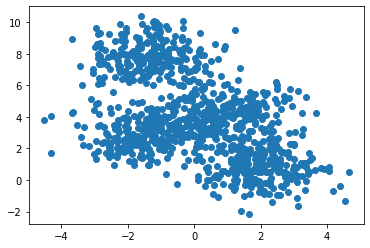

In [17]:
plt.scatter(X[:,0], X[:,1])

In [18]:
kmeans = KMeans(3)

kmeans.fit(X)

pred = kmeans.predict(X)

distortion = kmeans.distortion(X)

In [19]:
print(distortion)

2719.8748693596676


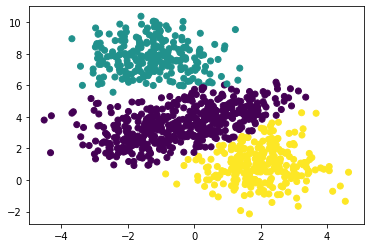

In [20]:
plt.scatter(X[:,0], X[:,1], c=pred)

## 6. Gaussian Mixed Models

In [21]:
class GMM:
    def __init__(self, k, tolerance=1e-6):
        self.k = k 
        self.tolerance = tolerance
        self.mean = None
        self.covariance = None
        self.pi = None
        
    def initialize(self, X):
        series = np.arange(X.shape[0])
        np.random.shuffle(series)
        centers = X[series[:self.k]]
        self.pi = np.full((self.k),1/self.k)
        self.mean = centers
        self.covariance = np.array([np.cov(X.T) for _ in range(self.k)])
    
    def expectation(self,X):
        from scipy.stats import multivariate_normal
        m,n = X.shape
        r = np.zeros(shape=(m,self.k))
        pdf = np.zeros_like(r)
        for i in range(m):
            for k in range(self.k):
                xi_pdf = multivariate_normal.pdf(X[i], mean=self.mean[k], cov=self.covariance[k])
                pdf[i, k] = self.pi[k] * xi_pdf
            r[i] = pdf[i] / np.sum(pdf[i])
        return r, pdf
    
    def maximization(self,X,r):
        m,n = X.shape
        
        NK = np.sum(r, axis=0)
        pi = NK / m
        mean =  (( X.T @ r ) / NK).T
        cov = np.zeros_like(self.covariance)
        for k in range(self.k):
            for i in range(m):
                diff = (X[i]-mean[k]).reshape(-1, 1)
                cov[k] += r[i, k] * (diff @ diff.T)
            cov[k] /= NK[k]
        return pi, mean, cov
            
    def fit(self, X):
        self.initialize(X)
        
        while True:
            r, pdf = self.expectation(X)
            pi, mean, cov = self.maximization(X, r)

            if(np.sum((mean-self.mean)**2) < self.tolerance):
                break
            else:
                self.pi = pi
                self.mean = mean
                self.covariance = cov
        
    def predict(self, X):
        r, pdf = self.expectation(X)
        pred = np.argmax(r,axis=1)
        return pred
    
    def distortion(self, X):
        r, pdf = self.expectation(X)
        pdf_max = np.max(pdf,axis=1)
        log_pdf_max = np.log(pdf_max)
        return np.mean(log_pdf_max)

In [22]:
X, y = make_blobs(n_samples=1000, cluster_std=[1.0, 3.5, 0.5], random_state=42)

In [23]:
gmm = GMM(3)
gmm.fit(X)

pred = gmm.predict(X)

print(gmm.distortion(X))

-4.263265510117041


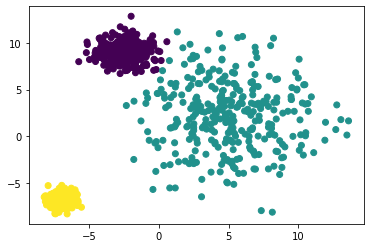

In [24]:
plt.scatter(X[:,0],X[:,1],c=pred)

## 7. Neural Network

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [26]:
X, y = make_blobs(n_samples=100, cluster_std=[1.0, 3.5, 0.5], random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [27]:
X_train_nn = torch.Tensor(X_train)
y_train_nn = torch.Tensor(y_train).long()

X_test_nn = torch.Tensor(X_test)
y_test_nn = torch.Tensor(y_test).long()

In [28]:
train_dataset = TensorDataset(X_train_nn,y_train_nn)
train_dataloader = DataLoader(train_dataset, batch_size=10,shuffle=True)

In [29]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(nn.Linear(2,10), nn.ReLU(),
                                nn.Linear(10,10), nn.ReLU(),
                                  nn.Linear(10,3))

    def forward(self,x):
        x = self.fc(x)
        return x

In [30]:
net = Net().cuda()

In [31]:
import torch.optim as optim

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [32]:
from IPython.display import clear_output
import copy

EPOCHS = 100

best_loss = torch.Tensor(np.array(float('inf')))
best_idx = 0

for epoch in range(EPOCHS):
    for i,data in enumerate(train_dataloader):
        net.train()
        
        batch_X, batch_y = data
        batch_X = batch_X.cuda()
        batch_y = batch_y.cuda()
        
        net.zero_grad()
        output = net(batch_X)
        loss = loss_function(output,batch_y)
        
        loss.backward()
        optimizer.step()
        
        if i % 5 == 0:
            net.eval()
            with torch.no_grad():
                X_test_nn = X_test_nn.cuda()
                y_test_nn = y_test_nn.cuda()
                pred = net(X_test_nn)
                test_loss = loss_function(pred,y_test_nn)
                if test_loss < best_loss:
                    best_loss = test_loss
                    best_model = copy.deepcopy(net)
                    best_idx = epoch
                    print("copied")
        
            clear_output(wait=True)
            print(f"Epoch: {epoch}\t Loss: {loss}\t Test Loss: {test_loss}")

Epoch: 99	 Loss: 0.0027484826277941465	 Test Loss: 0.0021031941287219524


In [33]:
print(best_idx)

99


In [34]:
best_model = best_model.cpu()

In [35]:
X = torch.Tensor(X)
y = torch.Tensor(y)

pred = best_model(X)
prediction = torch.argmax(pred,dim=1)
print("Accuracy:",(sum(prediction==y)/float(y.size()[0])).item())

Accuracy: 1.0


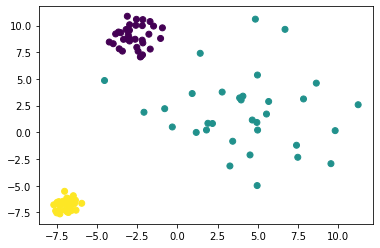

In [36]:
plt.scatter(X[:,0],X[:,1],c=prediction)